<a href="https://colab.research.google.com/github/adrianmarino/neural-network-from-scratch/blob/master/Neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Neural Network From Scratch

In [0]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

## 1. Utilities used to plot and inspect (DO NOT READ THIS SECTION INITIALLY, GO TO SECTION 2 :) )

In this session only exist utils and helper classes for inspect network structure.**This code is not important to interstand  hwo works a Neural network.** 

In [0]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            position = (n*h_spacing + left, layer_top - m*v_spacing)
            circle = plt.Circle(
                (n*h_spacing + left, layer_top - m*v_spacing), 
                v_spacing/4.,
                color= 'w',
                ec='k',
                zorder=4
            )
            ax.add_artist(circle)
            delta = (0.0003, 0.005)
            ax.annotate(
                'N' if n else 'I', 
                xy=(position[0] - delta[0], position[1] - delta[1]), 
                fontsize=10, 
                ha="center",
                zorder=5
            )
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

In [0]:
class NetworkPlotter:
    def __init__(self, network): self.network = network

    def __layers_size(self):
        layers = []
        for index,layer in enumerate(self.network.layers):
            layers.append(layer.inputs)
            if index == len(self.network.layers) - 1:
               layers.append(layer.neurons)
        return layers

    def __topology(self):
        return pd.DataFrame(
             [(l.name(), l.inputs,l.neurons, l.act_fn.name()) for l in self.network.layers],
            columns=['Layer', 'Inputs', 'Neurons', 'Activation']
        )

    def plot(self):
        fig = plt.figure(figsize=(14, 14))
        ax = fig.gca()
        ax.axis('off')
        draw_neural_net(ax, .1, .9, .1, .9, self.__layers_size())
        fig.savefig('nn.png')
        return self.__topology()


In [0]:
class DatasetPlotter:
    def __init__(self, dataset): self.dataset = dataset

    def plot(self):
        plt.scatter(
            self.dataset.X[self.dataset.y[:, 0] == 0, 0], 
            self.dataset.X[self.dataset.y[:, 0] == 0, 1],
            c='skyblue'
        )
        plt.scatter(
            self.dataset.X[self.dataset.y[:, 0] == 1, 0], 
            self.dataset.X[self.dataset.y[:, 0] == 1, 1],
            c='salmon'
        )
        plt.axis('equal')
        plt.grid()
        plt.show()

In [0]:
class FunctionPlotter:
    def __init__(self, function): self.function = function

    def plot(self, x_values):
        plt.title(f'{self.function.name()} Function')
        plt.grid()
        plt.plot(x_values, [self.function.compute(x) for x in x_values])
        plt.show()

In [0]:
def normal_rand_tensor(*dimensions):
    """Allow create a tensor with specified dimensions 
    and random values bethween -1 and 1.
    
    Examples: 
        - normal_rand_tensor(2): Create a two elements array. 
        - normal_rand_tensor(2, 2): Create (2, 2) matrix.
        - normal_rand_tensor(2, 2, 2): Create (2, 2, 3) tensor.
        - etc...
    """
    return np.random.rand(*dimensions) * 2 -1

In [0]:
class TrainSummary:
    def __init__(self):
        self.__epochs = []
        self.__losses = []
        self.__val_losses = []
    
    def add(self, epoch, train_loss, val_loss):
        self.__epochs.append(epoch)
        self.__losses.append(train_loss)
        if val_loss:
            self.__val_losses.append(val_loss)
    
    def as_table(self):
        return pd.DataFrame(self.__rows, columns=['Epoch', 'Train Loss', 'Validation Loss']) 

    def plot(self):
        plt.grid()
        plt.plot(self.__epochs, self.__losses, 'b')
        if self.__val_losses:
            plt.plot(self.__epochs, self.__val_losses, 'g')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def rows(self): return self.__rows

    def show(self):
        self.plot()
        return self.as_table()

## 2. Create dataset (BEGIN TO READ FROM THIS POIT!)

In [0]:
class CirclesDataset:
    def __init__(self, samples_count, factor, noise, shuffle=True):
        self.X, y = make_circles(
            n_samples=samples_count, 
            shuffle=True,
            factor=factor,
            noise=noise
        )
        # Change self.labels shape from (labels_count, ) to (labels_count, 1)..
        self.y = np.reshape(y, (y.shape[0], 1))

    def train_test(self, test_size):
        return train_test_split(self.X, self.y, test_size=test_size, shuffle=True)

    def plot(self): DatasetPlotter(self).plot()

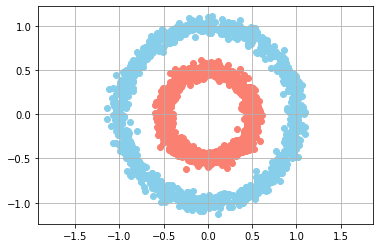

In [370]:
dataset = CirclesDataset(
    samples_count=2_000, 
    factor=0.5, 
    noise=0.05, 
    shuffle=True
)
dataset.plot()

## 3. Activation functions

In [0]:
from abc import ABCMeta, abstractmethod

# Abstract Class
class Function(metaclass=ABCMeta):
    @abstractmethod
    def compute(self, x): pass

    def derivate(self): return None
    
    def name(self): return self.__class__.__name__
    
    def plot(self, x_values): FunctionPlotter(self).plot(x_values)

In [0]:
class SigmoideFunction(Function):
    def compute(self, x): return 1 / (1 + np.e ** (-x))
    def derivate(self): return SigmoideDerivateFunction()

class SigmoideDerivateFunction(Function):
    def compute(self, x): return x * (1 -x)

In [0]:
class RELUFunction(Function):
    def compute(self, x): return np.maximum(0, x)
    def derivate(self): return RELUDerivateFunction()

class RELUDerivateFunction(Function):
    def compute(self, x): return 1 if x == 1 else 0

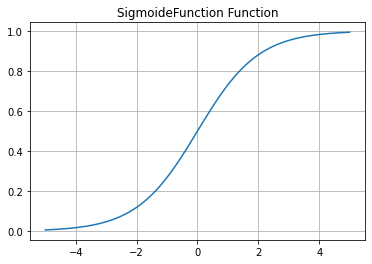

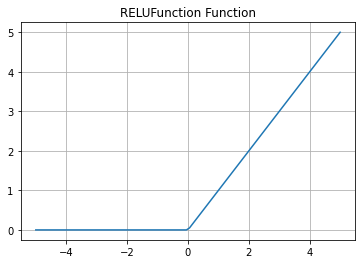

In [374]:
SigmoideFunction().plot(x_values=np.linspace(-5, 5, 100))
RELUFunction().plot(x_values=np.linspace(-5, 5, 100))

## 4. Neural network Layers

In [0]:
class LayerOutput:
    def __init__(self, weighted_sum, activation):
       self.weighted_sum = weighted_sum
       self.activation = activation

In [0]:
class DenseLayer:
    def __init__(self, inputs, neurons, act_fn):
        self.inputs = inputs
        self.neurons = neurons
        self.act_fn = act_fn
        self.biases = normal_rand_tensor(1,    )
        self.W = normal_rand_tensor(inputs, neurons)

    def name(self): return 'Dense'

    def compute(self, inputs):
        weighted_sum = inputs @ self.W + self.biases
        activation = self.act_fn.compute(weighted_sum)
        return LayerOutput(weighted_sum, activation) 

## 5. Neural network builder

In [0]:
class NetworkBuilder:
    def __init__(self): self.__layers = []
    
    def build(self): return Network(self.__layers)

    def resolve_inputs(self, default_inputs): 
        return self.__layers[-1].neurons if len(self.__layers) > 0 else default_inputs

    def dense(self, activation, neurons, inputs=-1):
        inputs = self.resolve_inputs(inputs)
        layer = DenseLayer(inputs, neurons, activation)
        self.__layers.append(layer)
        return self

    def sigm_dense(self, neurons, inputs=-1): 
        self.dense(SigmoideFunction(), neurons, inputs)
        return self

    def relu_dense(self, neurons, inputs=-1): 
        self.dense(RELUFunction(), neurons, inputs)
        return self

## 6. Neural network

In [0]:
class Network:
    def __init__(self, layers): self.layers = layers
    
    @staticmethod
    def builder(): return NetworkBuilder()
    
    def plot(self): return NetworkPlotter(self).plot() 

    def __forward_pass(self, X):
        outputs = []
        for layer in self.layers:
            # if outputs: is the pythonic way to do this: if len(outputs) > 0
            activation = outputs[-1].activation if outputs else X
            outputs.append(layer.compute(activation))
        return outputs

    def predict(self, X):
        outputs = self.__forward_pass(X)
        return outputs[-1].activation

    def __backward_propagation(self, loss_fn, outputs, Y):
        errors = [] # Or deltas
        for layer_index in reversed(range(0, len(self.layers))):
            layer = self.layers[layer_index]
            act_value = outputs[layer_index].activation

            if not errors: # Is last layer?
                first_term = loss_fn.derivate().compute(act_value, Y)
            else:
                previous_layer = self.layers[layer_index + 1]
                previous_error = errors[0]
                first_term = previous_error @ previous_layer.W.T

            second_term = layer.act_fn.derivate().compute(act_value)
            errors.insert(0, first_term * second_term)
        return errors 
    
    def __gradient_desent_optimization(self, outputs, errors, lr):
        for layer_index in reversed(range(0, len(self.layers))):
            layer = self.layers[layer_index]
            layer_error = errors[layer_index]
            layer_output = outputs[layer_index]

            mean_layer_error = np.mean(layer_error, axis=0, keepdims=True)
            mean_layer_act = np.mean(
                layer_output.activation, axis=0, keepdims=True)

            layer.biases = layer.biases - (mean_layer_error * lr)

            layer.W = layer.W - (mean_layer_error * mean_layer_act  * lr)

    def train(self, train_set, loss_fn, lr, epochs, validation_set = []):
        X, Y = train_set
        summary = TrainSummary()

        with tqdm(range(1, epochs + 1), unit='Epoch') as pbar:
            for epoch in range(1, epochs + 1):
                outputs = self.__forward_pass(X)
                errors = self.__backward_propagation(loss_fn, outputs, Y)
                self.__gradient_desent_optimization(outputs, errors, lr)

                train_loss = loss_fn.compute(outputs[-1].activation, Y)

                val_loss = None
                if validation_set:
                    X_val, y_val = validation_set
                    val_y_pred = self.predict(X_val)                
                    val_loss = np.mean(loss_fn.compute(val_y_pred, y_val))

                summary.add(epoch, train_loss, val_loss)

                pbar.update()
                pbar.desc = f'Loss: {val_loss} '

        return summary

## 7. Loss functions

In [0]:
# Mean square error function

class MSEFunction(Function):
    def compute(self, Yp, Yr): return np.mean((Yp - Yr) ** 2)
    def derivate(self): return MSEDerivateFunction()

class MSEDerivateFunction(Function):
    def compute(self, Yp, Yr): return Yp - Yr


## 8. Build and train network

,Layer,Inputs,Neurons,Activation
0,Dense,2,4,SigmoideFunction
1,Dense,4,8,SigmoideFunction
2,Dense,8,8,SigmoideFunction
3,Dense,8,8,SigmoideFunction
4,Dense,8,4,SigmoideFunction
5,Dense,4,1,SigmoideFunction


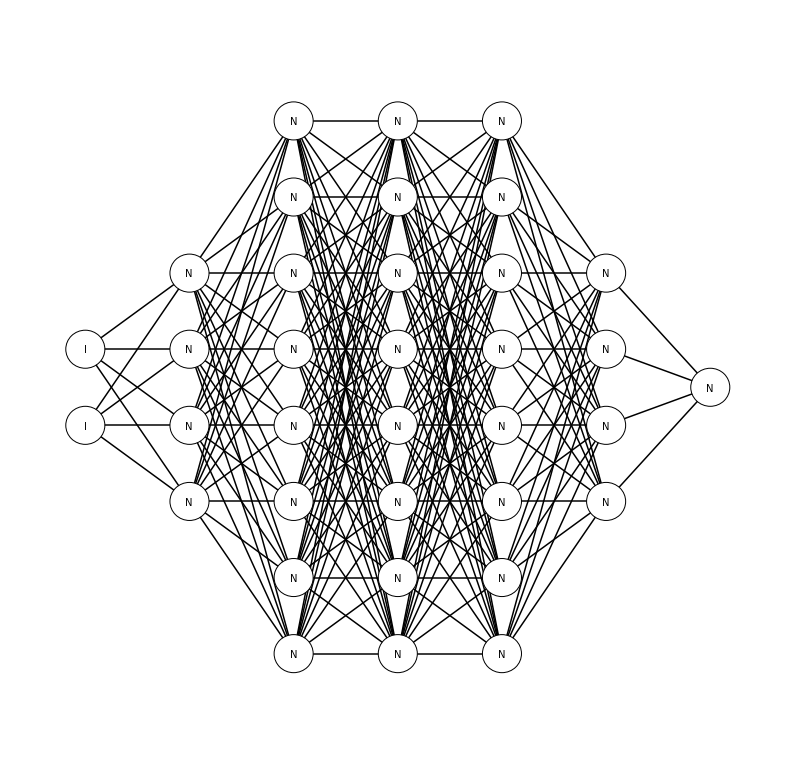

In [380]:
network = Network.builder() \
    .sigm_dense(neurons = 4, inputs = 2) \
    .sigm_dense(neurons = 8) \
    .sigm_dense(neurons = 8) \
    .sigm_dense(neurons = 8) \
    .sigm_dense(neurons = 4) \
    .sigm_dense(neurons = 1) \
    .build()

network.plot()

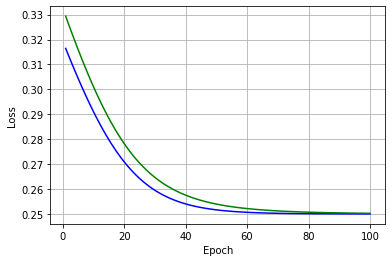

In [381]:
X_train, X_validation, y_train, y_validation = dataset.train_test(0.3)

summary = network.train(
    train_set=(dataset.X, dataset.y),
   validation_set=(X_validation,y_validation),
    loss_fn=MSEFunction(),
    lr=0.5,
    epochs=100
)
summary.plot()